In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


import numpy as np
import pandas as pd

import os


In [ ]:
!pip install tensorflow numpy pandas matplotlib seaborn opencv-python tqdm scikit-learn --quiet


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Conv2D

In [ ]:
disease_types = ['Bacterial Leaf Disease','Fungal Brown Spot Disease','Dried Leaf','Healthy Leaf']
data_dir = '/content/drive/MyDrive/Betal Leaf_Project/Aug_data'
train_dir = os.path.join(data_dir)
# test_dir = os.path.join(data_dir, 'test')

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head(3)

,File,DiseaseID,Disease Type
0,Bacterial Leaf Disease/Bacterial_Leaf_Spot_Dis...,0,Bacterial Leaf Disease
1,Bacterial Leaf Disease/Bacterial_Leaf_Spot_Dis...,0,Bacterial Leaf Disease
2,Bacterial Leaf Disease/Bacterial_Leaf_Spot_Dis...,0,Bacterial Leaf Disease


In [ ]:
len(train_data)

2589

In [ ]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Fungal Brown Spot Disease/Fungal_Brown_Spot_Di...,1,Fungal Brown Spot Disease
1,Fungal Brown Spot Disease/Fungal_Brown_Spot_Di...,1,Fungal Brown Spot Disease
2,Healthy Leaf/Healthy_Leaf-172-_jpg.rf.b83c0567...,3,Healthy Leaf
3,Bacterial Leaf Disease/Bacterial_Leaf_Spot_Dis...,0,Bacterial Leaf Disease
4,Fungal Brown Spot Disease/Fungal_Brown_Spot_Di...,1,Fungal Brown Spot Disease


In [ ]:
IMAGE_SIZE = 224

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = image

3798it [07:13,  8.75it/s]


In [ ]:
X_Train = X_train / 255.0
print('Train Shape: {}'.format(X_train.shape))

Train Shape: (3798, 224, 224, 3)


In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=4)

In [ ]:
BATCH_SIZE = 64

X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

In [ ]:
EPOCHS = 100
SIZE=224
N_ch=3

# Resnet

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

def resenet():
    base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, N_ch))

    # Input layer
    inputs = Input(shape=(SIZE, SIZE, N_ch))

    # Stacked convolutional layers
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(3, (3, 3), padding='same')(x)

    # Use the base model
    x = base_model(x)

    # Global average pooling
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Fully connected layers
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Add another dense layer
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(4, activation='softmax', name='root')(x)

    # Define the model
    model = Model(inputs, outputs)

    for layer in base_model.layers:
        layer.trainable = False

    optimizer = Adam(learning_rate=0.002)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Build the model
model = resenet()


234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
from sklearn.utils import class_weight

y_train_indices = np.argmax(Y_train, axis=1)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_indices),
    y=y_train_indices
)

class_weights = {i: class_weights[i] for i in range(len(class_weights))}


In [ ]:

annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=5, min_lr=2e-5)
checkpoint = ModelCheckpoint('model.keras', verbose=1, save_best_only=True)


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)


In [ ]:
hist = model.fit(
    datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2,
    callbacks=[annealer, checkpoint, early_stopping],
    validation_data=(X_val, Y_val),
    class_weight=class_weights,
    shuffle=True
)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 - 136s - 4s/step - accuracy: 0.4988 - loss: 1.5397 - val_accuracy: 0.2278 - val_loss: 6.1908 - learning_rate: 0.0020
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


32/32 - 6s - 199ms/step - accuracy: 0.6406 - loss: 1.0456 - val_accuracy: 0.2278 - val_loss: 5.8388 - learning_rate: 0.0020
Epoch 3/100
32/32 - 48s - 1s/step - accuracy: 0.5595 - loss: 1.0594 - val_accuracy: 0.2394 - val_loss: 2.7734 - learning_rate: 0.0020
Epoch 4/100
32/32 - 7s - 212ms/step - accuracy: 0.6094 - loss: 1.0111 - val_accuracy: 0.2394 - val_loss: 2.7285 - learning_rate: 0.0020
Epoch 5/100
32/32 - 40s - 1s/step - accuracy: 0.5874 - loss: 0.9872 - val_accuracy: 0.2375 - val_loss: 1.8362 - learning_rate: 0.0020
Epoch 6/100
32/32 - 5s - 152ms/step - accuracy: 0.5781 - loss: 0.9699 - val_accuracy: 0.2394 - val_loss: 1.8027 - learning_rate: 0.0020
Epoch 7/100
32/32 - 64s - 2s/step - accuracy: 0.6079 - loss: 0.9197 - val_accuracy: 0.4479 - val_loss: 1.1160 - learning_rate: 0.0020
Epoch 8/100
32/32 - 73s - 2s/step - accuracy: 0.6406 - loss: 0.7516 - val_accuracy: 0.4556 - val_loss: 1.1162 - learning_rate: 0.0020
Epoch 9/100
32/32 - 126s - 4s/step - accuracy: 0.5949 - loss: 0.8825

KeyboardInterrupt: 

In [ ]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9267 - loss: 0.1890
Final Loss: 0.20372629165649414, Final Accuracy: 0.9266409277915955


17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 706ms/step


Text(0.5, 192.72222222222217, 'Predicted')

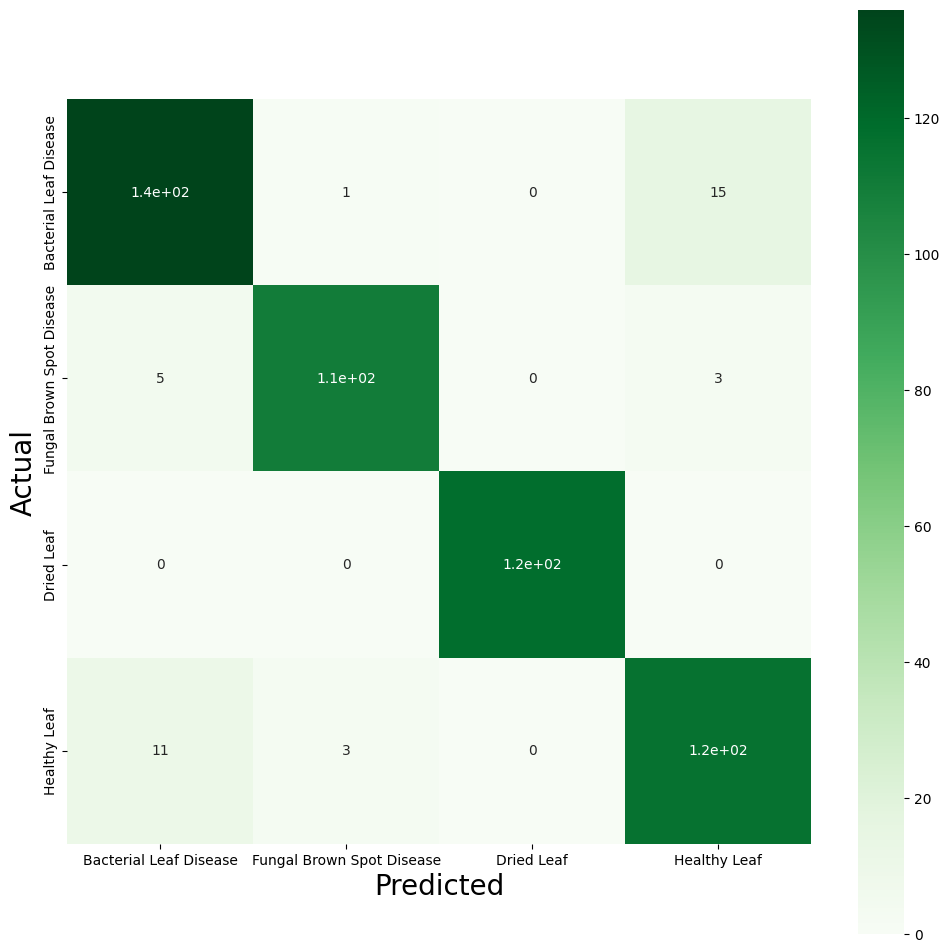

In [ ]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

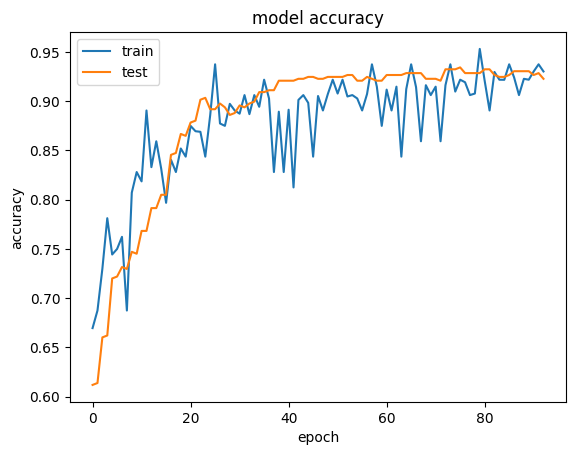

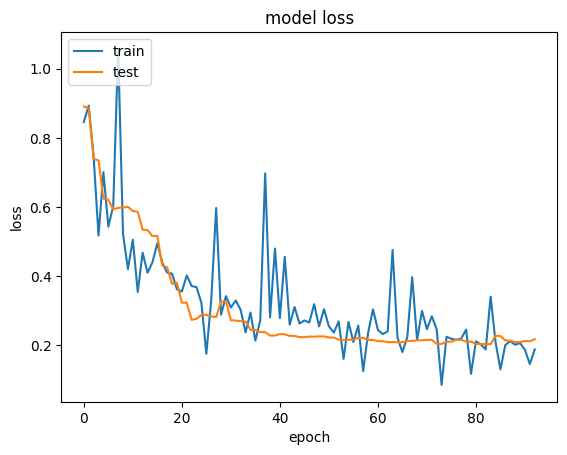

In [ ]:

# accuracy plot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()